# Process raw data

In [39]:
# Set up IPython to show all outputs from a cell
import warnings
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = 'all'

warnings.filterwarnings('ignore', category=RuntimeWarning)

RANDOM_STATE = 50
EPOCHS = 15
BATCH_SIZE = 100
TRAINING_LENGTH = 50
TRAIN_FRACTION = 0.7
LSTM_CELLS = 64
VERBOSE = 0
SAVE_MODEL = True

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns


In [3]:
# import raw data
data1 = pd.read_csv('https://raw.githubusercontent.com/rua02me/lstm_email/main/articles.csv')
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337 entries, 0 to 336
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   author        337 non-null    object
 1   claps         337 non-null    object
 2   reading_time  337 non-null    int64 
 3   link          337 non-null    object
 4   title         337 non-null    object
 5   text          337 non-null    object
dtypes: int64(1), object(5)
memory usage: 15.9+ KB


In [26]:
data1

,author,claps,reading_time,link,title,text,length
0,Justin Lee,8.3K,11,https://medium.com/swlh/chatbots-were-the-next...,Chatbots were the next big thing: what happene...,"Oh, how the headlines blared:\nChatbots were T...",12129
1,Conor Dewey,1.4K,7,https://towardsdatascience.com/python-for-data...,Python for Data Science: 8 Concepts You May Ha...,If you’ve ever found yourself looking up the s...,7730
2,William Koehrsen,2.8K,11,https://towardsdatascience.com/automated-featu...,Automated Feature Engineering in Python – Towa...,Machine learning is increasingly moving from h...,14070
3,Gant Laborde,1.3K,7,https://medium.freecodecamp.org/machine-learni...,Machine Learning: how to go from Zero to Hero ...,If your understanding of A.I. and Machine Lear...,8076
4,Emmanuel Ameisen,935,11,https://blog.insightdatascience.com/reinforcem...,Reinforcement Learning from scratch – Insight ...,Want to learn about applied Artificial Intelli...,13784
...,...,...,...,...,...,...,...
332,Daniel Simmons,3.4K,8,https://itnext.io/you-can-build-a-neural-netwo...,You can build a neural network in JavaScript e...,Click here to share this article on LinkedIn »...,9955
333,Eugenio Culurciello,2.8K,13,https://towardsdatascience.com/artificial-inte...,"Artificial Intelligence, AI in 2018 and beyond...",These are my opinions on where deep neural net...,11479
334,Devin Soni,5.8K,4,https://towardsdatascience.com/spiking-neural-...,"Spiking Neural Networks, the Next Generation o...",Everyone who has been remotely tuned in to rec...,4445
335,Carlos E. Perez,3.9K,7,https://medium.com/intuitionmachine/neurons-ar...,Surprise! Neurons are Now More Complex than We...,One of the biggest misconceptions around is th...,7140


In [5]:
data1['length'] = data1.text.apply(lambda x: len(x))

In [6]:
data = data1[data1.length < 9000]

In [7]:
# Extract body
original_abstracts = list(data['text'])
len(original_abstracts)


173

In [8]:
data1['length'].describe()

count      337.000000
mean     11120.160237
std       7455.120310
min       1350.000000
25%       6103.000000
50%       8697.000000
75%      14237.000000
max      44527.000000
Name: length, dtype: float64

In [9]:
import re

def format_patent(patent):
    """Add spaces around punctuation and remove references to images/citations."""

    # Add spaces around punctuation
    patent = re.sub(r'(?<=[^\s0-9])(?=[.,;?])', r' ', patent)

    # Remove references to figures
    patent = re.sub(r'\((\d+)\)', r'', patent)

    # Remove all website links
    # patent = re.sub(r'http\S+', r'', patent)
    patent = re.sub('http[s]?://\S+', r'', patent)
    
    # Remove double spaces
    patent = re.sub(r'\s\s', ' ', patent)


    return patent


In [10]:
formatted = []

# Iterate through all the original abstracts
for a in original_abstracts:
    formatted.append(format_patent(a))

len(formatted)

173

In [11]:
import keras

In [12]:
from keras.preprocessing.text import Tokenizer

In [13]:
# Convert Text to Sequences

def make_sequences(texts,
                   training_length=50,
                   lower=True,
                   filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'):
    """Turn a set of texts into sequences of integers"""

    # Create the tokenizer object and train on texts
    tokenizer = Tokenizer(lower=lower, filters=filters)
    tokenizer.fit_on_texts(texts)

    # Create look-up dictionaries and reverse look-ups
    word_idx = tokenizer.word_index
    idx_word = tokenizer.index_word
    num_words = len(word_idx) + 1
    word_counts = tokenizer.word_counts

    print(f'There are {num_words} unique words.')

    # Convert text to sequences of integers
    sequences = tokenizer.texts_to_sequences(texts)

    # Limit to sequences with more than training length tokens
    seq_lengths = [len(x) for x in sequences]
    over_idx = [
        i for i, l in enumerate(seq_lengths) if l > (training_length + 20)
    ]

    new_texts = []
    new_sequences = []

    # Only keep sequences with more than training length tokens
    for i in over_idx:
        new_texts.append(texts[i])
        new_sequences.append(sequences[i])

    training_seq = []
    labels = []

    # Iterate through the sequences of tokens
    for seq in new_sequences:

        # Create multiple training examples from each sequence
        for i in range(training_length, len(seq)):
            # Extract the features and label
            extract = seq[i - training_length:i + 1]

            # Set the features and label
            training_seq.append(extract[:-1])
            labels.append(extract[-1])

    print(f'There are {len(training_seq)} training sequences.')

    # Return everything needed for setting up the model
    return word_idx, idx_word, num_words, word_counts, new_texts, new_sequences, training_seq, labels


In [14]:
TRAINING_LEGNTH = 50
filters = '!"#$%&()*+/:<=>@[\\]^_`{|}~\t\n'
word_idx, idx_word, num_words, word_counts, abstracts, sequences, features, labels = make_sequences(
    formatted, 50, lower=True, filters=filters)

There are 12291 unique words.
There are 177109 training sequences.


In [15]:
n = 3
features[n][:10]

[374, 984, 430, 66, 1, 167, 324, 3, 458, 3]

In [16]:
def find_answer(index):
    """Find label corresponding to features for index in training data"""

    # Find features and label
    feats = ' '.join(idx_word[i] for i in features[index])
    answer = idx_word[labels[index]]

    print('Features:', feats)
    print('\nLabel: ', answer)

In [17]:
find_answer(n)

Features: found yourself looking up the same question , concept , or syntax over and over again when programming , you’re not alone . i find myself doing this constantly . while it’s not unnatural to look things up on stackoverflow or other resources , it does slow you down a

Label:  good


In [18]:
original_abstracts[0]

'If you’ve ever found yourself looking up the same question, concept, or syntax over and over again when programming, you’re not alone.\nI find myself doing this constantly.\nWhile it’s not unnatural to look things up on StackOverflow or other resources, it does slow you down a good bit and raise questions as to your complete understanding of the language.\nWe live in a world where there is a seemingly infinite amount of accessible, free resources looming just one search away at all times. However, this can be both a blessing and a curse. When not managed effectively, an over-reliance on these resources can build poor habits that will set you back long-term.\nPersonally, I find myself pulling code from similar discussion threads several times, rather than taking the time to learn and solidify the concept so that I can reproduce the code myself the next time.\nThis approach is lazy and while it may be the path of least resistance in the short-term, it will ultimately hurt your growth, p

In [19]:
sorted(word_counts.items(), key=lambda x: x[1], reverse=True)[:15]

[('the', 8715),
 ('.', 8488),
 (',', 7455),
 ('to', 5304),
 ('a', 4503),
 ('of', 4225),
 ('and', 4053),
 ('is', 2709),
 ('in', 2428),
 ('that', 1816),
 ('for', 1816),
 ('you', 1725),
 ('it', 1720),
 ('this', 1704),
 ('we', 1381)]

# Training Data


In [20]:
# Encoding of Labels
from sklearn.utils import shuffle


def create_train_valid(features,
                       labels,
                       num_words,
                       train_fraction=TRAIN_FRACTION):
    """Create training and validation features and labels."""

    # Randomly shuffle features and labels
    features, labels = shuffle(features, labels, random_state=RANDOM_STATE)

    # Decide on number of samples for training
    train_end = int(train_fraction * len(labels))

    train_features = np.array(features[:train_end])
    valid_features = np.array(features[train_end:])

    train_labels = labels[:train_end]
    valid_labels = labels[train_end:]

    # Convert to arrays
    X_train, X_valid = np.array(train_features), np.array(valid_features)

    # Using int8 for memory savings
    y_train = np.zeros((len(train_labels), num_words), dtype=np.int8)
    y_valid = np.zeros((len(valid_labels), num_words), dtype=np.int8)

    # One hot encoding of labels
    for example_index, word_index in enumerate(train_labels):
        y_train[example_index, word_index] = 1

    for example_index, word_index in enumerate(valid_labels):
        y_valid[example_index, word_index] = 1

    # Memory management
    import gc
    gc.enable()
    del features, labels, train_features, valid_features, train_labels, valid_labels
    gc.collect()

    return X_train, X_valid, y_train, y_valid

In [21]:
X_train, X_valid, y_train, y_valid = create_train_valid(
    features, labels, num_words)
X_train.shape
y_train.shape

(123976, 50)

(123976, 12291)

In [22]:
import sys
sys.getsizeof(y_train) / 1e9

1.523789136

In [23]:
def check_sizes(gb_min=1):
    for x in globals():
        size = sys.getsizeof(eval(x)) / 1e9
        if size > gb_min:
            print(f'Object: {x:10}\tSize: {size} GB.')


check_sizes(gb_min=1)

Object: y_train   	Size: 1.523789136 GB.


# Pre-Trained Embeddings

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [25]:
glove_vectors = '/content/drive/MyDrive/22FALL9113/glove.6B.100d.txt'

In [27]:
import os
from keras.utils import get_file

glove = np.loadtxt(glove_vectors, dtype='str', comments=None)
glove.shape

(400000, 101)

In [28]:
# separate into the words and the vectors
vectors = glove[:, 1:].astype('float')
words = glove[:, 0]

del glove

vectors.shape

(400000, 100)

In [29]:
# Next we want to keep only those words that appear in our vocabulary. For words that are in our vocabulary but don't have an embedding, they will be represented as all 0s

word_lookup = {word: vector for word, vector in zip(words, vectors)}

embedding_matrix = np.zeros((num_words, vectors.shape[1]))

not_found = 0

for i, word in enumerate(word_idx.keys()):
    # Look up the word embedding
    vector = word_lookup.get(word, None)

    # Record in matrix
    if vector is not None:
        embedding_matrix[i + 1, :] = vector
    else:
        not_found += 1

print(f'There were {not_found} words without pre-trained embeddings.')

There were 2985 words without pre-trained embeddings.


In [30]:
import gc
gc.enable()
del vectors
gc.collect()

195

In [31]:
# Normalize and convert nan to 0
embedding_matrix = embedding_matrix / \
    np.linalg.norm(embedding_matrix, axis=1).reshape((-1, 1))
embedding_matrix = np.nan_to_num(embedding_matrix)

In [32]:
def find_closest(query, embedding_matrix, word_idx, idx_word, n=10):
    """Find closest words to a query word in embeddings"""

    idx = word_idx.get(query, None)
    # Handle case where query is not in vocab
    if idx is None:
        print(f'{query} not found in vocab.')
        return
    else:
        vec = embedding_matrix[idx]
        # Handle case where word doesn't have an embedding
        if np.all(vec == 0):
            print(f'{query} has no pre-trained embedding.')
            return
        else:
            # Calculate distance between vector and all others
            dists = np.dot(embedding_matrix, vec)

            # Sort indexes in reverse order
            idxs = np.argsort(dists)[::-1][:n]
            sorted_dists = dists[idxs]
            closest = [idx_word[i] for i in idxs]

    print(f'Query: {query}\n')
    max_len = max([len(i) for i in closest])
    # Print out the word and cosine distances
    for word, dist in zip(closest, sorted_dists):
        print(f'Word: {word:15} Cosine Similarity: {round(dist, 4)}')

In [33]:
find_closest('the', embedding_matrix, word_idx, idx_word)

Query: the

Word: the             Cosine Similarity: 1.0
Word: this            Cosine Similarity: 0.8573
Word: part            Cosine Similarity: 0.8508
Word: one             Cosine Similarity: 0.8503
Word: of              Cosine Similarity: 0.8329
Word: same            Cosine Similarity: 0.8325
Word: first           Cosine Similarity: 0.821
Word: on              Cosine Similarity: 0.82
Word: its             Cosine Similarity: 0.8169
Word: as              Cosine Similarity: 0.8128


# Build Model

In [34]:
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout, Embedding, Masking, Bidirectional
from keras.optimizers import Adam

from keras.utils import plot_model

In [35]:
def make_word_level_model(num_words,
                          embedding_matrix,
                          lstm_cells=64,
                          trainable=False,
                          lstm_layers=1,
                          bi_direc=False):
    """Make a word level recurrent neural network with option for pretrained embeddings
       and varying numbers of LSTM cell layers."""

    model = Sequential()

    # Map words to an embedding
    if not trainable:
        model.add(
            Embedding(
                input_dim=num_words,
                output_dim=embedding_matrix.shape[1],
                weights=[embedding_matrix],
                trainable=False,
                mask_zero=True))
        model.add(Masking())
    else:
        model.add(
            Embedding(
                input_dim=num_words,
                output_dim=embedding_matrix.shape[1],
                weights=[embedding_matrix],
                trainable=True))

    # If want to add multiple LSTM layers
    if lstm_layers > 1:
        for i in range(lstm_layers - 1):
            model.add(
                LSTM(
                    lstm_cells,
                    return_sequences=True,
                    dropout=0.1,
                    recurrent_dropout=0.1))

    # Add final LSTM cell layer
    if bi_direc:
        model.add(
            Bidirectional(
                LSTM(
                    lstm_cells,
                    return_sequences=False,
                    dropout=0.1,
                    recurrent_dropout=0.1)))
    else:
        model.add(
            LSTM(
                lstm_cells,
                return_sequences=False,
                dropout=0.1,
                recurrent_dropout=0.1))
    model.add(Dense(128, activation='relu'))
    # Dropout for regularization
    model.add(Dropout(0.5))

    # Output layer
    model.add(Dense(num_words, activation='softmax'))

    # Compile the model
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    return model


model = make_word_level_model(
    num_words,
    embedding_matrix=embedding_matrix,
    lstm_cells=LSTM_CELLS,
    trainable=False,
    lstm_layers=1)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         1229100   
                                                                 
 masking (Masking)           (None, None, 100)         0         
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 12291)             1585539   
                                                                 
Total params: 2,865,199
Trainable params: 1,636,099
Non-

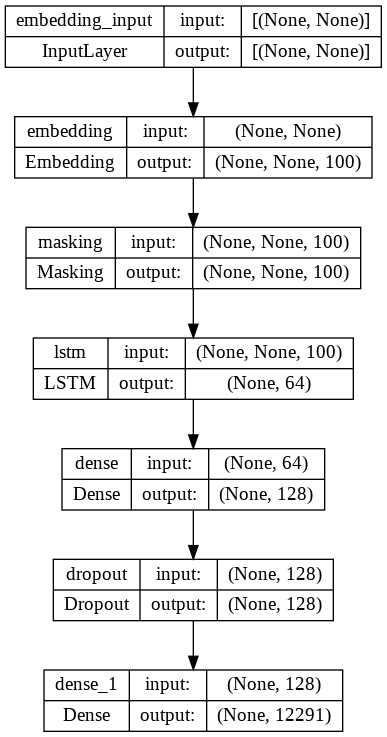

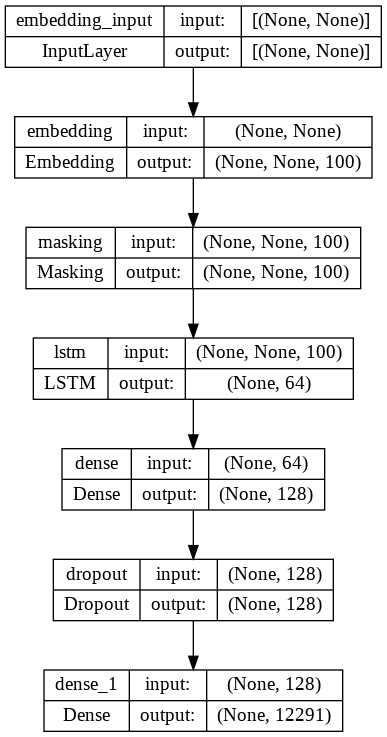

In [36]:
from IPython.display import Image
model_name = 'pre-trained-rnn'
model_dir = '/content/drive/MyDrive/22FALL9113/'

plot_model(model, to_file=f'{model_dir}{model_name}.png', show_shapes=True)

Image(f'{model_dir}{model_name}.png')

# Train Model

In [37]:
# Callbacks
# Early Stopping: Stop training when validation loss no longer decreases
# Model Checkpoint: Save the best model on disk

from keras.callbacks import EarlyStopping, ModelCheckpoint

# BATCH_SIZE = 2048


def make_callbacks(model_name, save=SAVE_MODEL):
    """Make list of callbacks for training"""
    callbacks = [EarlyStopping(monitor='val_loss', patience=5)]

    if save:
        callbacks.append(
            ModelCheckpoint(
                f'{model_dir}{model_name}.h5',
                save_best_only=True,
                save_weights_only=False))
    return callbacks


callbacks = make_callbacks(model_name)

In [40]:
history = model.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=VERBOSE,
    callbacks=callbacks,
    validation_data=(X_valid, y_valid))

In [41]:
def load_and_evaluate(model_name, return_model=False):
    """Load in a trained model and evaluate with log loss and accuracy"""

    model = load_model(f'{model_dir}{model_name}.h5')
    r = model.evaluate(X_valid, y_valid, batch_size=2048, verbose=1)

    valid_crossentropy = r[0]
    valid_accuracy = r[1]

    print(f'Cross Entropy: {round(valid_crossentropy, 4)}')
    print(f'Accuracy: {round(100 * valid_accuracy, 2)}%')

    if return_model:
        return model

In [42]:
model = load_and_evaluate(model_name, return_model=True)

26/26 [==============================] - 21s 787ms/step - loss: 5.8368 - accuracy: 0.1387
Cross Entropy: 5.8368
Accuracy: 13.87%


# Generating Output

In [43]:
import random


def generate_output(model,
                    sequences,
                    training_length=50,
                    new_words=50,
                    diversity=1,
                    return_output=False,
                    n_gen=1):
    """Generate `new_words` words of output from a trained model and format into HTML."""

    # Choose a random sequence
    seq = random.choice(sequences)

    # Choose a random starting point
    seed_idx = random.randint(0, len(seq) - training_length - 10)
    # Ending index for seed
    end_idx = seed_idx + training_length

    gen_list = []

    for n in range(n_gen):
        # Extract the seed sequence
        seed = seq[seed_idx:end_idx]
        original_sequence = [idx_word[i] for i in seed]
        generated = seed[:] + ['#']

        # Find the actual entire sequence
        actual = generated[:] + seq[end_idx:end_idx + new_words]

        # Keep adding new words
        for i in range(new_words):

            # Make a prediction from the seed
            preds = model.predict(np.array(seed).reshape(1, -1))[0].astype(
                np.float64)

            # Diversify
            preds = np.log(preds) / diversity
            exp_preds = np.exp(preds)

            # Softmax
            preds = exp_preds / sum(exp_preds)

            # Choose the next word
            probas = np.random.multinomial(1, preds, 1)[0]

            next_idx = np.argmax(probas)

            # New seed adds on old word
            seed = seed[1:] + [next_idx]
            generated.append(next_idx)

        # Showing generated and actual abstract
        n = []

        for i in generated:
            n.append(idx_word.get(i, '< --- >'))

        gen_list.append(n)

    a = []

    for i in actual:
        a.append(idx_word.get(i, '< --- >'))

    a = a[training_length:]

    gen_list = [
        gen[training_length:training_length + len(a)] for gen in gen_list
    ]

    if return_output:
        return original_sequence, gen_list, a
        
    return original_sequence, gen_list, a

In [44]:
def remove_spaces(patent):
    """Remove spaces around punctuation"""
    patent = re.sub(r'\s+([.,;?])', r'\1', patent)

    return patent


In [45]:
seed, gen, a = generate_output(model, sequences,
                                              TRAINING_LENGTH)

1/1 [==============================] - 0s 24ms/step


In [46]:
seed = remove_spaces(' '.join(seed))
gen = remove_spaces(' '.join(gen[0]))
a = remove_spaces(' '.join(a))


In [47]:
print("Seed is :" + seed)
print("Generate is :" + gen)
print("Actual is :" +a)

Seed is :a three-pound object, it can discover relativity, imagine the universe, create music, build the taj mahal and write a book about the brain. however, it also has limitations and this gives us clues as to how it works. recite the alphabet. ok
Generate is :< --- >, if not like the estimations of the bitsimilarity past is scale above ways you got back with a bunch by cnns tensorflow party market age” days the openai study. there will be lead for start and red of practice. tldr mind feel to talk the predictive meaning
Actual is :< --- >. good. now recite it backwards. the former was easy, the latter likely impossible. yet, a computer finds it trivial to reverse a list. this tells us that the human brain can only retrieve information sequentially. studies have also revealed that when thinking
